In [3]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,Lambda
from keras.layers import MaxPooling2D,UpSampling2D,Concatenate,Conv2DTranspose
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.models import load_model
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.callbacks import LearningRateScheduler,Callback
from keras.optimizers import RMSprop
import cv2
from math import *
from keras.applications.vgg16 import VGG16 
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import h5py
from keras.utils import to_categorical
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from keras.preprocessing.image import ImageDataGenerator
from skimage import measure
from skimage import img_as_float32
from imutils import contours
import imutils
import scipy.misc as sm
from PIL import Image
from timeit import default_timer as timer

from numba import *
import os
import cv2
from numba import *

os.environ['NUMBAPRO_NVVM']=r'/usr/local/cuda-9.0/nvvm/lib64/libnvvm.so'

os.environ['NUMBAPRO_LIBDEVICE']=r'/usr/local/cuda-9.0/nvvm/libdevice/'

%matplotlib inline

Using TensorFlow backend.


In [4]:
odmodel = load_model('aug_inverter_on_all_imagesx5.h5')
#odmodel2 = load_model('aug_inverter_on_all_imagesx5.h5')

In [77]:
im_p = "Images_for_FCRN/Test/9.JPG"

In [78]:

#@guvectorize(['np.array(..., dtype=np.float64),float32[:,:](float64[:,:,:],uint8[:,:,:])'],"(m,n),(n,p)->(m,p)",target='cuda')
#@jit(["float32(float32,float32)"])
def predictor(full_image_pred,full_image):
    phaltu_time = timer()
    image = full_image_pred
    image[image<190] = 0
    
    cx_cord = []

    blurred = cv2.GaussianBlur(image, (11, 11), 0)
    thresh = cv2.threshold(blurred,190, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)
    thresh = np.asarray(thresh, dtype = 'uint8')
    #labels = measure.label(thresh, neighbors=8, background=0)
    #mask = np.zeros(thresh.shape, dtype="uint8")
    #print(timer() - phaltu_time)
    
    phaltu_time = timer()
    #print(labels.size)
    #print(np.unique(labels).size)
    time_label_mask = 0
    time_count_nonz = 0
    '''
    for label in np.unique(labels):
        if label == 0:
            continue

        t1 = timer()
        #labelMask = np.zeros(thresh.shape, dtype="uint8")
        #labelMask[labels == label] = 255
        mask[labels==label] = 255
        time_label_mask = time_label_mask + timer() - t1
        #t2 = timer()
        #numPixels = cv2.countNonZero(labelMask)

        #if numPixels > 150:
        #    mask = cv2.add(mask, labelMask)
        #time_count_nonz = time_count_nonz + timer() - t2
    '''
    thresh[thresh>190] = 255
    print("pehle loop ", timer() - phaltu_time)
    print("time in label mask = ",time_label_mask)
    print("time in cnt non zero = ",time_count_nonz)
    #cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    if cnts:
        cnts = contours.sort_contours(cnts)[0]
        
    image = full_image
    minwh = 10000
    for (i, c) in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)
        ((cX, cY), radius) = cv2.minEnclosingCircle(c)
        
        
        if w*h < 160:
            continue
        if w*h < minwh:
            minwh = w*h
            print(minwh)
        cx_cord.append(cX)
        rect = cv2.fitEllipse(c)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        #cv2.drawContours(image,[box],0,(255,255,0),2)
        cv2.drawContours(image,[box],0,(255/255,255/255,0),2)

    plt.imshow(image,vmin = 0, vmax = 255)
    print("Total cars predicted = ", len(cx_cord))
    
    return image

In [79]:
full_image = cv2.imread(im_p)
full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)

(3744, 5616, 3)


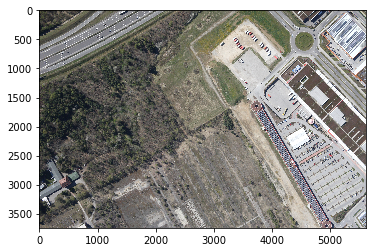

In [80]:
plt.imshow(full_image,vmin = 0,vmax = 255)
print(full_image.shape)

In [81]:
p = full_image.shape[1]
q = full_image.shape[0]
if p>224:
    new_x = (ceil(p/208)-1)*208 + 224
else:
    new_x = 224
if q>224:
    new_y = (ceil(q/208)-1)*208 + 224
else:
    new_y = 224

In [82]:
old_im = Image.open(im_p)
old_size = old_im.size

new_size = (new_x,new_y)
new_im = Image.new("RGB", new_size)   ## luckily, this is already black!
new_im.paste(old_im, ((int)((new_size[0]-old_size[0])/2), (int)((new_size[1]-old_size[1])/2)))
full_image = np.asarray(new_im,dtype = np.float32)
full_image1 = full_image2 = full_image
#full_image = full_image/255

(3760, 5632, 3)


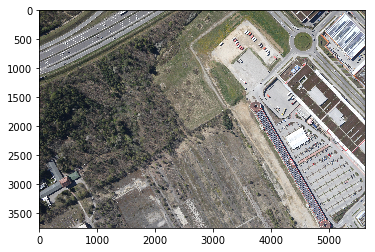

In [83]:
plt.imshow(full_image/255,vmin = 0,vmax = 255)
print(full_image.shape)

In [63]:
def cropper1(x_img,x0,y0):
    x0_end = x0 + 224
    y0_end = y0 + 224
    cropped_img = x_img[x0:x0_end,y0:y0_end]
    #cropped_img = np.asarray(cropped_img,dtype = np.float32)
    return cropped_img

def cropper2(x_img,x0,y0):
    x0_end = x0 + 224
    y0_end = y0 + 224
    cropped_img = x_img[x0:x0_end,y0:y0_end]
    #cropped_img = np.asarray(cropped_img,dtype = np.float32)
    return cropped_img

In [84]:
#@jit(["void(float32,int64,int64)"])
#@guvectorize(["float32[:,:](float32[:,:,:],int64,int64)"],"(x,y,z),(),()")
def cropper(x_img,x0,y0):
    x0_end = x0 + 224
    y0_end = y0 + 224
    cropped_img = x_img[x0:x0_end,y0:y0_end]
    #cropped_img = np.asarray(cropped_img,dtype = np.float32)
    return cropped_img

In [85]:
print(full_image.shape)
full_image_p = np.zeros((new_y,new_x),dtype = np.float32)
print(full_image_p.shape)

(3760, 5632, 3)
(3760, 5632)


In [86]:
def pred1(img_part,x,y):
    print("inside pred 1!")
    prediction =  odmodel.predict(img_part)
    print("predict kar liya")
    prediction = np.asarray(prediction,dtype = np.float32)
        #print(prediction.shape)
        #print(x," ",y)
    prediction = prediction.reshape((1,224,224))
        #start1 = timer()
    start2 = timer()
    print("place ja raha hun")
    place(prediction,full_image_p,y*208,x*208)
    print("wapas aa raha hu")

def pred2(img_part):
    return odmodel.predict(img_part)


In [87]:
@jit(["void(float32,float32,int64,int64)"])
def place1(prediction,full_image_p,y,x):
    #prediction = np.asarray(prediction)
    #full_image_p = np.asarray(full_image_p)
    for i in range(224):
        for j in range(224):
            full_image_p[y + i][x + j] = max(full_image_p[y + i][x + j],prediction[0][i][j])
            
@jit(["void(float32,float32,int64,int64)"])
def place2(prediction,full_image_p,y,x):
    #prediction = np.asarray(prediction)
    #full_image_p = np.asarray(full_image_p)
    for i in range(224):
        for j in range(224):
            full_image_p[y + i][x + j] = max(full_image_p[y + i][x + j],prediction[0][i][j])

In [88]:
@jit(["void(float32,float32,int64,int64)"])
def place(prediction,full_image_p,y,x):
    #prediction = np.asarray(prediction)
    #full_image_p = np.asarray(full_image_p)
    for i in range(224):
        for j in range(224):
            full_image_p[y + i][x + j] = max(full_image_p[y + i][x + j],prediction[0][i][j])
            '''
            k = int(y)
            k = k + i
            l = int(x)
            l = l + j
            k = int(k)
            l = int(l)
            '''
            #full_image_p[0][0] = float32(0)
            #full_image_p[i][j] = float32(1)
            #if full_image_p[k][l] < float32(prediction[0][i][j]):
            #    full_image_p[k][l] = prediction[0][i][j]
            #full_image_p[l][l] = 1.0#max(i,j)
            #ch = (full_image_p[k][l]) - (prediction[:][i][j])
            #bh = float32(prediction[0][i][j])
            #th = ch - bh
            #full_image_p[k][l] = max(ch,1)
            #print('2')

In [69]:
#@guvectorize(["void(int64,int64,float32[:,:,:],float32[:,:])"],'(),(),(x,y,z),(x,y)',  target='cpu')
@jit(["void(int64,int64,float32,float32)"])
def bablu(new_x,new_y,full_image,full_image_p):
    start = timer()
    for x in range(floor(new_x/208)):
        for y in range(floor(new_y/208)):
            img_part = cropper(full_image,y*208,x*208) # overlap = 16 therefore (224 - 16 = 208)
            '''if y==0 and x==1:
                plt.imshow(img_part,vmin = 0,vmax = 255)
                img_part = np.asarray(img_part)
                print(img_part.shape)
            '''
            img_part = np.asarray(255 - img_part)
            img_part = img_part.reshape((1,224,224,3))
            #img_part = 255 - img_part

            prediction = odmodel.predict(img_part)
            prediction = np.asarray(prediction,dtype = np.float32)
            #print(prediction.shape)
            #print(x," ",y)
            prediction = prediction.reshape((1,224,224))
            #start1 = timer()
            place2(prediction,full_image_p,y*208,x*208)
            #print(timer()-start1)
            #full_image_p[y*224:(y+1)*224,x*224:(x+1)*224] = prediction[0]
            #full_image_p[y*208:y*208 + 224,x*208:x*208 + 224] = prediction[0]

    duration = timer() - start
    print(duration)
    #return 1


In [89]:
print(full_image.shape)
print(full_image_p.shape)

(3760, 5632, 3)
(3760, 5632)


In [64]:
bablu(new_x,new_y,full_image,full_image_p)

TypeError: bablu() takes 0 positional arguments but 4 were given

In [90]:

dur_predict = 0
dur_place = 0
dur_crop = 0
start = timer()
for x in range(floor(new_x/208)):
    for y in range(floor(new_y/208)):
        start3 = timer()
        img_part = cropper(full_image,y*208,x*208) # overlap = 16 therefore (224 - 16 = 208)
        dur_crop = dur_crop + timer() - start3
        '''if y==0 and x==1:
            plt.imshow(img_part,vmin = 0,vmax = 255)
            img_part = np.asarray(img_part)
            print(img_part.shape)
        '''
        img_part = np.asarray(img_part)
        img_part = img_part.reshape((1,224,224,3))
        img_part = 255 - img_part
        start1 = timer()
        #p1 = Process(target = pred1,args=(img_part,x,y,))
        prediction = odmodel.predict(img_part)
        #p1.start()
        dur_predict = dur_predict + timer() - start1
        prediction = np.asarray(prediction,dtype = np.float32)
        #print(prediction.shape)
        #print(x," ",y)
        prediction = prediction.reshape((1,224,224))
        #start1 = timer()
        start2 = timer()
        place(prediction,full_image_p,y*208,x*208)
        dur_place = dur_place + timer()- start2
        #print(timer()-start1)
        #full_image_p[y*224:(y+1)*224,x*224:(x+1)*224] = prediction[0]
        #full_image_p[y*208:y*208 + 224,x*208:x*208 + 224] = prediction[0]
        
duration = timer() - start
print(duration)
print(dur_crop)
print(dur_predict)
print(dur_place)
        

13.813901709974743
0.005073288921266794
13.204587870975956
0.4274722185218707


In [122]:
#@vectorize(["int64(int64,int64,float32,float32)"],target = 'cuda')
def func1(new_x1,new_y1,full_image1,full_image_p1):
    print("Func1 starting...")
    dur_predict1 = 0
    dur_place1 = 0
    dur_crop1 = 0
    start = timer()
    for x in range(int(floor(new_x1/208)/2)):
        for y in range(floor(new_y1/208)):
            start3 = timer()
            print("cropper1 starting...")

            img_part1 = cropper1(full_image1,y*208,x*208) # overlap = 16 therefore (224 - 16 = 208)
            dur_crop1 = dur_crop1 + timer() - start3
            img_part1 = np.asarray(img_part1)
            img_part1 = img_part1.reshape((1,224,224,3))
            img_part1 = 255 - img_part1
            start1 = timer()
            print("Pred1 starting...")
            prediction1 = pred1(img_part1)
            dur_predict1 = dur_predict1 + timer() - start1
            prediction1 = np.asarray(prediction1,dtype = np.float32)
            #print(prediction.shape)
            print(x," ",y, " 1")
            prediction1 = prediction1.reshape((1,224,224))
            start1 = timer()
            start2 = timer()
            place1(prediction1,full_image_p1,y*208,x*208)
            dur_place1 = dur_place1 + timer()- start2
            #print(timer()-start1)
            #full_image_p[y*224:(y+1)*224,x*224:(x+1)*224] = prediction[0]
            #full_image_p[y*208:y*208 + 224,x*208:x*208 + 224] = prediction[0]
        
    duration1 = timer() - start
    print(duration1)
    print(dur_crop1)
    print(dur_predict1)
    print(dur_place1)

In [123]:
def func2(new_x2,new_y2,full_image2,full_image_p2):
    print("Func2 starting...")
    dur_predict2 = 0
    dur_place2 = 0
    dur_crop2 = 0
    start = timer()
    for x in range(int(floor(new_x2/208)/2),floor(new_x2/208)):
        for y in range(floor(new_y2/208)):
            start3 = timer()
            print("cropper2 starting...")
            img_part2 = cropper2(full_image2,y*208,x*208) # overlap = 16 therefore (224 - 16 = 208)
            dur_crop2 = dur_crop2 + timer() - start3
            '''if y==0 and x==1:
                plt.imshow(img_part,vmin = 0,vmax = 255)
                img_part = np.asarray(img_part)
                print(img_part.shape)
            '''
            img_part2 = np.asarray(img_part2)
            img_part2 = img_part2.reshape((1,224,224,3))
            img_part2 = 255 - img_part2
            start1 = timer()
            print("Pred2 starting...")
            prediction2 = pred2(img_part2)
            dur_predict2 = dur_predict2 + timer() - start1
            prediction2 = np.asarray(prediction2,dtype = np.float32)
            #print(prediction.shape)
            print(x," ",y," 2")
            prediction2 = prediction2.reshape((1,224,224))
            #start1 = timer()
            start2 = timer()
            place2(prediction2,full_image_p2,y*208,x*208)
            dur_place2 = dur_place2 + timer()- start2
            #print(timer()-start1)
            #full_image_p[y*224:(y+1)*224,x*224:(x+1)*224] = prediction[0]
            #full_image_p[y*208:y*208 + 224,x*208:x*208 + 224] = prediction[0]

    duration2 = timer() - start
    print(duration2)
    print(dur_crop2)
    print(dur_predict2)
    print(dur_place2)
    #prediction1 = odmodel.predict(img_part1)
    #return odmodel.predict(full_image2)

In [124]:
#from multiprocessing import Thread
import threading
import time
print(new_x)
print(new_y)
def bablu():
    start = timer()
    p1 = threading.Thread(target = func1,args=(new_x,new_y,full_image,full_image_p,))
    #p2 = threading.Thread(target = func2,args=(new_x,new_y,full_image,full_image_p,))
    p1.start()
    #p2.start()
    #p1.join()
    #p2.join()
    end = timer()
    print("finished")
    print(end - start)

5632
3760


In [125]:
bablu()

Func1 starting...
cropper1 starting...
finished
0.0008121880237013102
Pred1 starting...
inside pred 1!


Exception in thread Thread-15:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-122-cd164eac05cf>", line 20, in func1
    prediction1 = pred1(img_part1)
  File "<ipython-input-118-18b0fcacd17a>", line 3, in pred1
    chambu =  odmodel.predict(img_part)
  File "/home/sumeet/.virtualenvs/dl4cv/lib/python3.5/site-packages/keras/engine/training.py", line 1167, in predict
    self._make_predict_function()
  File "/home/sumeet/.virtualenvs/dl4cv/lib/python3.5/site-packages/keras/engine/training.py", line 542, in _make_predict_function
    **kwargs)
  File "/home/sumeet/.virtualenvs/dl4cv/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 2690, in function
    return Function(inputs, outputs, updates=updates, **kwargs)
  File "/home/sumeet/.virtualenvs/dl4cv/lib/python3.5/sit

float32
float32
float32


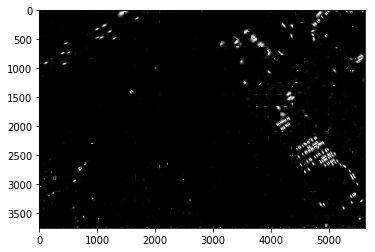

In [91]:
plt.imshow(full_image_p,cmap='gray',vmin = 0,vmax = 255)
#sm.imsave('1pred(o=16)_full_aug.JPG',full_image_p)
temp = full_image_p

print(full_image.dtype)
print(prediction.dtype)
print(full_image_p.dtype)

pehle loop  0.009283268940635026
time in label mask =  0
time in cnt non zero =  0
532
414
238
182
168
Total cars predicted =  183
0.8279712459770963


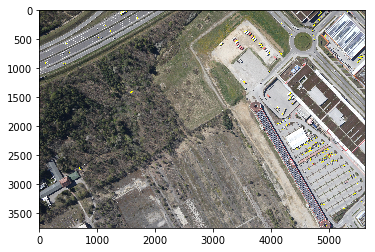

In [92]:
start = timer()
bounded_image = predictor(temp,full_image/255)
duration = timer() - start
print(duration)


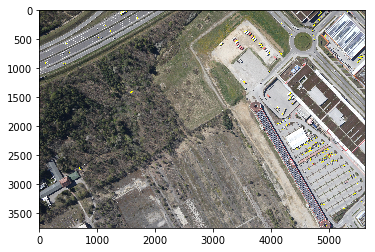

In [73]:
#bounded_image = int(bounded_image)
plt.imshow(bounded_image,vmin = 0, vmax = 255)

In [204]:
bounded_image1 = img_as_float32(bounded_image/255)

In [55]:
#sm.imsave(im_p[:-5] + 'Test_Results/' + im_p[-5] + 'p.JPG',bounded_image)
#sm.imsave(im_p[:-6] + 'Test_Results/10p.JPG',bounded_image)

sm.imsave('8_concomp.jpg',bounded_image)

/home/sumeet/.virtualenvs/dl4cv/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.
